In [1]:
import os
import sys
from zipfile import ZipFile
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/34478398/import-local-function-
# from-a-module-housed-in-another-directory-with-relative-im
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import local_module as local

# Data Caveats

- The geographic fatality data will not total the tabular fatality data because some of the tabular records do not have valid geographic information.
- Some of the fatality points lie on the borders of multiple census tracts, and are assigned to a single tract based on programmatic rules in the pandas library.
- 

# Geographic Data

In [2]:
url = r"https://www2.census.gov/geo/tiger/TIGER2021/TRACT/"
zips = local.get_zip(url)

dfs = [] # initialize empty list to hold tract geodataframes

for file in zips:
    dfs.append(gp.read_file(file)) # read in tract files and add to list

tracts = pd.concat(dfs) # combine tracts into single geodataframe
# tracts.to_file("../data/raw/tracts.geojson", driver="GeoJSON") # export to local file

/opt/anaconda3/envs/gds/lib/python3.9/site-packages/urllib3/connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www2.census.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [3]:
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,01,079,979201,01079979201,9792.01,Census Tract 9792.01,G5020,S,173543715,33343864,+34.7177132,-087.3401349,"POLYGON ((-87.43611 34.72743, -87.43610 34.727..."
1,01,079,979202,01079979202,9792.02,Census Tract 9792.02,G5020,S,132640589,788347,+34.6396492,-087.3633477,"POLYGON ((-87.45696 34.61352, -87.45693 34.613..."
2,01,079,979502,01079979502,9795.02,Census Tract 9795.02,G5020,S,75015361,645300,+34.5569960,-087.2404514,"POLYGON ((-87.29614 34.54337, -87.29610 34.543..."
3,01,079,979501,01079979501,9795.01,Census Tract 9795.01,G5020,S,42596424,343043,+34.5828012,-087.1533184,"POLYGON ((-87.20741 34.55710, -87.20740 34.557..."
4,01,009,050103,01009050103,501.03,Census Tract 501.03,G5020,S,101604725,5974506,+33.8656656,-086.5073198,"POLYGON ((-86.57229 33.82070, -86.57229 33.820..."


<AxesSubplot:>

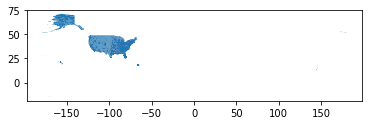

In [4]:
tracts.plot()

# FARS Data

In [5]:
col_dict = {
    "person.csv": [
        "ST_CASE",
        "VEH_NO",
        "PER_NO", # p. 248 of 2022 User Manual PDF
        "PER_TYP", # p.265 of 2022 User Manual PDF
        # "PER_TYPNAME", # p.265 of 2022 User Manual PDF
        "INJ_SEV", # p.267 of 2022 User Manual PDF
        "INJ_SEVNAME" # p.267 of 2022 User Manual PDF
    ],
    "accident.CSV": [
        "ST_CASE",
        "LATITUDE", # p.67 of User Manual PDF
        "LONGITUD" # p.68 of User Manual PDF
    ]
}

In [7]:
dfs = {} # initialize dictionary to hold dfs
url = "https://static.nhtsa.gov/nhtsa/downloads/FARS/2020/National/FARS2020NationalCSV.zip" # current year url
filenames = [
    "person.csv",
    "accident.CSV"
]

for i in filenames:
    
    # get function to retrieve CSV file from ZIP
    df = local.fetch_multi_csv_zip_from_url(
        url, 
        filenames=filenames,
        usecols=col_dict[i],
        encoding_errors="surrogateescape", # deal with encoding errors
        low_memory=False # deal with multiple dtypes in one column
    )
    # add name and df as 
    # key:value pair in dict
    dfs[i] = df

ValueError: Usecols do not match columns, columns expected but not found: ['LATITUDE', 'LONGITUD']

In [6]:
# citation: https://stackoverflow.com/questions/44575251/reading-multiple-files-contained-in-a-zip-file-with-pandas
# this should work but doesn't

zip_file = ZipFile('../data/raw/FARS2020NationalCSV.zip')

# https://docs.python.org/3/library/codecs.html#error-handlers
# both files ran into decoding issues
accidents = pd.read_csv(zip_file.open("accident.CSV"), usecols=accident_cols, encoding_errors="surrogateescape")
person = pd.read_csv(zip_file.open("person.csv"), usecols=person_cols, encoding_errors="surrogateescape")

In [7]:
person.head()

,ST_CASE,VEH_NO,PER_NO,PER_TYP,INJ_SEV,INJ_SEVNAME
0,10001,1,1,1,4,Fatal Injury (K)
1,10001,1,2,2,3,Suspected Serious Injury (A)
2,10001,1,3,2,4,Fatal Injury (K)
3,10001,1,4,2,4,Fatal Injury (K)
4,10002,1,1,1,3,Suspected Serious Injury (A)


In [8]:
accidents.head()

,ST_CASE,LATITUDE,LONGITUD
0,10001,32.433133,-86.094850
1,10002,33.484658,-86.839544
2,10003,33.299942,-86.369642
3,10004,33.795072,-85.883486
4,10005,32.848414,-86.083547


In [9]:
# join spatial data from accidents to person data
fars = person.merge(accidents, how="left", on="ST_CASE", validate="m:1")

In [10]:
fars.head()

,ST_CASE,VEH_NO,PER_NO,PER_TYP,INJ_SEV,INJ_SEVNAME,LATITUDE,LONGITUD
0,10001,1,1,1,4,Fatal Injury (K),32.433133,-86.094850
1,10001,1,2,2,3,Suspected Serious Injury (A),32.433133,-86.094850
2,10001,1,3,2,4,Fatal Injury (K),32.433133,-86.094850
3,10001,1,4,2,4,Fatal Injury (K),32.433133,-86.094850
4,10002,1,1,1,3,Suspected Serious Injury (A),33.484658,-86.839544


In [11]:
# use lat/lon to create geometry
fars = gp.GeoDataFrame(fars, geometry=gp.points_from_xy(fars.LONGITUD, fars.LATITUDE), crs=4269)

<AxesSubplot:>

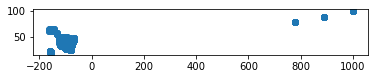

In [12]:
fars.plot()

In [13]:
# filter records to only fatal injuries
fars = fars.loc[fars["INJ_SEV"]==4]
fars

,ST_CASE,VEH_NO,PER_NO,PER_TYP,INJ_SEV,INJ_SEVNAME,LATITUDE,LONGITUD,geometry
0,10001,1,1,1,4,Fatal Injury (K),32.433133,-86.094850,POINT (-86.09485 32.43313)
2,10001,1,3,2,4,Fatal Injury (K),32.433133,-86.094850,POINT (-86.09485 32.43313)
3,10001,1,4,2,4,Fatal Injury (K),32.433133,-86.094850,POINT (-86.09485 32.43313)
5,10002,1,2,2,4,Fatal Injury (K),33.484658,-86.839544,POINT (-86.83954 33.48466)
10,10003,1,1,1,4,Fatal Injury (K),33.299942,-86.369642,POINT (-86.36964 33.29994)
...,...,...,...,...,...,...,...,...,...
85864,560112,2,1,1,4,Fatal Injury (K),42.814131,-110.957272,POINT (-110.95727 42.81413)
85865,560112,2,2,2,4,Fatal Injury (K),42.814131,-110.957272,POINT (-110.95727 42.81413)
85870,560113,1,1,1,4,Fatal Injury (K),42.993033,-108.406514,POINT (-108.40651 42.99303)
85879,560114,0,1,6,4,Fatal Injury (K),41.138478,-104.787133,POINT (-104.78713 41.13848)


In [14]:
# lat/lon values signifiying not reported, unavailable, or reported as unknown
lat_vals = [77.7777000, 88.8888000, 99.9999000]
lon_vals = [777.7777000, 888.8888000, 999.9999000]

In [15]:
# check to see which records have invalid location information
invalid_loc = fars.loc[fars["LATITUDE"].isin(lat_vals) | fars["LONGITUD"].isin(lon_vals)]
invalid_loc

,ST_CASE,VEH_NO,PER_NO,PER_TYP,INJ_SEV,INJ_SEVNAME,LATITUDE,LONGITUD,geometry
1462,10600,2,1,1,4,Fatal Injury (K),88.8888,888.8888,POINT (888.88880 88.88880)
2088,20006,0,1,5,4,Fatal Injury (K),77.7777,777.7777,POINT (777.77770 77.77770)
2454,40089,1,1,1,4,Fatal Injury (K),99.9999,999.9999,POINT (999.99990 99.99990)
2478,40098,1,2,2,4,Fatal Injury (K),99.9999,999.9999,POINT (999.99990 99.99990)
2482,40100,1,1,1,4,Fatal Injury (K),99.9999,999.9999,POINT (999.99990 99.99990)
...,...,...,...,...,...,...,...,...,...
79169,483264,0,1,5,4,Fatal Injury (K),77.7777,777.7777,POINT (777.77770 77.77770)
82701,530078,1,1,1,4,Fatal Injury (K),77.7777,777.7777,POINT (777.77770 77.77770)
82959,530202,1,2,2,4,Fatal Injury (K),99.9999,999.9999,POINT (999.99990 99.99990)
83009,530224,1,2,2,4,Fatal Injury (K),99.9999,999.9999,POINT (999.99990 99.99990)


In [16]:
# remove records with invalid location info
fars = fars[~fars.isin(invalid_loc)].dropna(how = 'all')

In [17]:
fars.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 38538 entries, 0 to 85883
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ST_CASE      38538 non-null  float64 
 1   VEH_NO       38538 non-null  float64 
 2   PER_NO       38538 non-null  float64 
 3   PER_TYP      38538 non-null  float64 
 4   INJ_SEV      38538 non-null  float64 
 5   INJ_SEVNAME  38538 non-null  object  
 6   LATITUDE     38538 non-null  float64 
 7   LONGITUD     38538 non-null  float64 
 8   geometry     38538 non-null  geometry
dtypes: float64(7), geometry(1), object(1)
memory usage: 2.9+ MB


In [18]:
# remap values in the PER_TYP column, 
# and combine unknown/other non-occupant categories 
fars = local.remap_PER_TYP(
    person_file=fars,
    year=2020, 
    combine=True
)

fars

,ST_CASE,VEH_NO,PER_NO,PER_TYP,INJ_SEV,INJ_SEVNAME,LATITUDE,LONGITUD,geometry
0,10001.0,1.0,1.0,Driver,4.0,Fatal Injury (K),32.433133,-86.094850,POINT (-86.09485 32.43313)
2,10001.0,1.0,3.0,Passenger,4.0,Fatal Injury (K),32.433133,-86.094850,POINT (-86.09485 32.43313)
3,10001.0,1.0,4.0,Passenger,4.0,Fatal Injury (K),32.433133,-86.094850,POINT (-86.09485 32.43313)
5,10002.0,1.0,2.0,Passenger,4.0,Fatal Injury (K),33.484658,-86.839544,POINT (-86.83954 33.48466)
10,10003.0,1.0,1.0,Driver,4.0,Fatal Injury (K),33.299942,-86.369642,POINT (-86.36964 33.29994)
...,...,...,...,...,...,...,...,...,...
85864,560112.0,2.0,1.0,Driver,4.0,Fatal Injury (K),42.814131,-110.957272,POINT (-110.95727 42.81413)
85865,560112.0,2.0,2.0,Passenger,4.0,Fatal Injury (K),42.814131,-110.957272,POINT (-110.95727 42.81413)
85870,560113.0,1.0,1.0,Driver,4.0,Fatal Injury (K),42.993033,-108.406514,POINT (-108.40651 42.99303)
85879,560114.0,0.0,1.0,Bicyclist,4.0,Fatal Injury (K),41.138478,-104.787133,POINT (-104.78713 41.13848)


<AxesSubplot:>

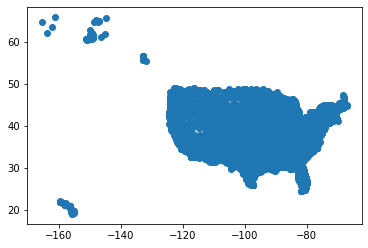

In [19]:
fars.plot()

# Joining Data

In [20]:
# calculate total 2022 fatalities per census tract
tracts = local.join_count(fars, tracts, "GEOID", "TOT_FATALITIES", ["ST_CASE", "VEH_NO", "PER_NO"])

In [21]:
categories = ['Pedestrian', 
              'Bicyclist',
              'Other/unknown non-occupant'
             ]

In [23]:
for category in categories:
    # subset category of interest
    subset = fars[fars["PER_TYP"] == category]
    
    # count the number of fatalities for the subset, and add as new attribute   
    tracts = local.join_count(subset, tracts, "GEOID", category.upper() + "_FATALITIES", ["ST_CASE", "VEH_NO", "PER_NO"])
    
    # calculate percentage of total fatalities in census tract as new attribute
    tracts["P_" + category.upper() + "_FATALITIES"] = tracts[category.upper() + "_FATALITIES"] / tracts["TOT_FATALITIES"]
    
    # quick check to see max fatalities in a census tract
    print(tracts[category.upper() + "_FATALITIES"].max())
    
# tracts = tracts.loc[:,"STATEFP": "TOT_FATALITIES"]

5.0
5.0
3.0


In [24]:
# replace NaN with 0 in percentage columns
tracts.fillna(
    {
    "P_PEDESTRIAN_FATALITIES": 0, 
    "P_BICYCLIST_FATALITIES": 0, 
    "P_OTHER/UNKNOWN NON-OCCUPANT_FATALITIES": 0
    }, inplace=True
)

In [25]:
tracts

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,TOT_FATALITIES,PEDESTRIAN_FATALITIES,P_PEDESTRIAN_FATALITIES,BICYCLIST_FATALITIES,P_BICYCLIST_FATALITIES,OTHER/UNKNOWN NON-OCCUPANT_FATALITIES,P_OTHER/UNKNOWN NON-OCCUPANT_FATALITIES
0,01,079,979201,01079979201,9792.01,Census Tract 9792.01,G5020,S,173543715,33343864,+34.7177132,-087.3401349,"POLYGON ((-87.43611 34.72743, -87.43610 34.727...",0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01,079,979202,01079979202,9792.02,Census Tract 9792.02,G5020,S,132640589,788347,+34.6396492,-087.3633477,"POLYGON ((-87.45696 34.61352, -87.45693 34.613...",0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01,079,979502,01079979502,9795.02,Census Tract 9795.02,G5020,S,75015361,645300,+34.5569960,-087.2404514,"POLYGON ((-87.29614 34.54337, -87.29610 34.543...",0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01,079,979501,01079979501,9795.01,Census Tract 9795.01,G5020,S,42596424,343043,+34.5828012,-087.1533184,"POLYGON ((-87.20741 34.55710, -87.20740 34.557...",0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01,009,050103,01009050103,501.03,Census Tract 501.03,G5020,S,101604725,5974506,+33.8656656,-086.5073198,"POLYGON ((-86.57229 33.82070, -86.57229 33.820...",0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85523,78,010,970500,78010970500,9705,Census Tract 9705,G5020,S,8281505,0,+17.7367518,-064.7453601,"POLYGON ((-64.75938 17.74196, -64.75857 17.742...",0.0,0.0,0.0,0.0,0.0,0.0,0.0
85524,78,010,970700,78010970700,9707,Census Tract 9707,G5020,S,15806699,143654,+17.7639765,-064.7888809,"POLYGON ((-64.82062 17.75921, -64.81715 17.760...",0.0,0.0,0.0,0.0,0.0,0.0,0.0
85525,78,010,970100,78010970100,9701,Census Tract 9701,G5020,S,28112089,3373334,+17.7495196,-064.6291392,"MULTIPOLYGON (((-64.62840 17.78893, -64.62836 ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0
85526,78,010,970600,78010970600,9706,Census Tract 9706,G5020,S,11324382,833399,+17.7636903,-064.7571442,"MULTIPOLYGON (((-64.74933 17.78710, -64.74930 ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# visualization
# https://code.activestate.com/recipes/577775-state-fips-codes-dict/
state_codes = {
    'WA': '53', 
    'DE': '10', 
    'DC': '11', 
    'WI': '55', 
    'WV': '54', 
    # 'HI': '15',
    'FL': '12', 
    'WY': '56', 
    # 'PR': '72', 
    'NJ': '34',
    'NM': '35', 
    'TX': '48',
    'LA': '22', 
    'NC': '37', 
    'ND': '38', 
    'NE': '31', 
    'TN': '47', 
    'NY': '36',
    'PA': '42', 
    # 'AK': '02', 
    'NV': '32', 
    'NH': '33', 
    'VA': '51', 
    'CO': '08',
    'CA': '06', 
    'AL': '01', 
    'AR': '05', 
    'VT': '50', 
    'IL': '17', 
    'GA': '13',
    'IN': '18', 
    'IA': '19', 
    'MA': '25', 
    'AZ': '04', 
    'ID': '16', 
    'CT': '09',
    'ME': '23', 
    'MD': '24', 
    'OK': '40', 
    'OH': '39', 
    'UT': '49', 
    'MO': '29',
    'MN': '27', 
    'MI': '26', 
    'RI': '44', 
    'KS': '20', 
    'MT': '30', 
    'MS': '28',
    'SC': '45', 
    'KY': '21', 
    'OR': '41', 
    'SD': '46'
}
state_codes = list(state_codes.values())
states = gp.read_file("https://www2.census.gov/geo/tiger/TIGER2021/STATE/tl_2021_us_state.zip")
states = states.loc[states["STATEFP"].isin(state_codes)] # cut to lower 48
tracts_viz = states.overlay(tracts, how='intersection')
tracts_viz.to_crs(epsg=6350, inplace=True)

/opt/anaconda3/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:2334: UserWarning: `keep_geom_type=True` in overlay resulted in 4476 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


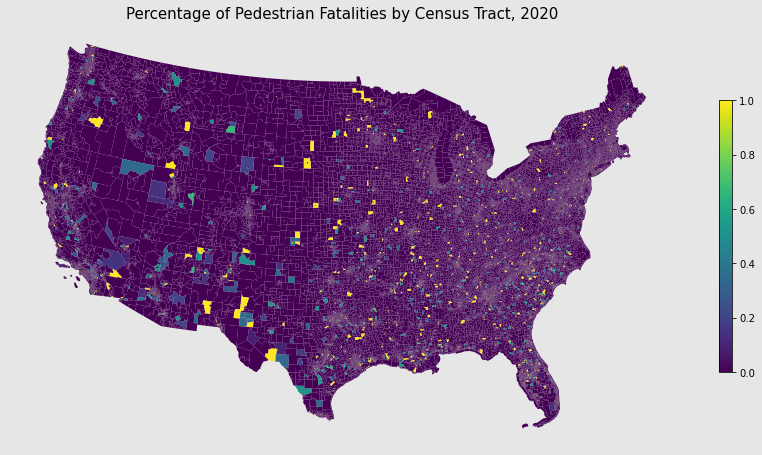

In [27]:
f, ax = plt.subplots(1, figsize=(15, 10))

tracts_viz.plot(
    column="P_PEDESTRIAN_FATALITIES", 
    linewidth=0,
    legend=True,
    legend_kwds={"shrink":0.5},
    ax=ax
)
ax.set_axis_off()
ax.set_title("Percentage of Pedestrian Fatalities by Census Tract, 2020", size=15)
f.set_facecolor('0.9')


# Products

In [28]:
# non-motorist fatalities by census tract for a single year
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,TOT_FATALITIES,PEDESTRIAN_FATALITIES,P_PEDESTRIAN_FATALITIES,BICYCLIST_FATALITIES,P_BICYCLIST_FATALITIES,OTHER/UNKNOWN NON-OCCUPANT_FATALITIES,P_OTHER/UNKNOWN NON-OCCUPANT_FATALITIES
0,01,079,979201,01079979201,9792.01,Census Tract 9792.01,G5020,S,173543715,33343864,+34.7177132,-087.3401349,"POLYGON ((-87.43611 34.72743, -87.43610 34.727...",0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01,079,979202,01079979202,9792.02,Census Tract 9792.02,G5020,S,132640589,788347,+34.6396492,-087.3633477,"POLYGON ((-87.45696 34.61352, -87.45693 34.613...",0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01,079,979502,01079979502,9795.02,Census Tract 9795.02,G5020,S,75015361,645300,+34.5569960,-087.2404514,"POLYGON ((-87.29614 34.54337, -87.29610 34.543...",0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01,079,979501,01079979501,9795.01,Census Tract 9795.01,G5020,S,42596424,343043,+34.5828012,-087.1533184,"POLYGON ((-87.20741 34.55710, -87.20740 34.557...",0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01,009,050103,01009050103,501.03,Census Tract 501.03,G5020,S,101604725,5974506,+33.8656656,-086.5073198,"POLYGON ((-86.57229 33.82070, -86.57229 33.820...",0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# tracts["TOT_FATALITIES"].sum()
# tracts["PEDESTRIAN_FATALITIES"].sum()
# tracts["BICYCLIST_FATALITIES"].sum()
# tracts["PERSONAL CONVEYANCE_FATALITIES"].sum()